In [1]:
import NetworkArchitectures as nets
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataset_utils import Format_Dataset
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import itertools

In [2]:
igps_dir = 'data/IGPS/'

# Let's start with IGPS for training and "testing" (really just validation)
features = [
    'BaselineMD', 'BaselineAGIS', 'MD', 'AGIS_score'
]

features = [
    'RNFL_average', 'mean_RNFL_thickness', 'cup_disk_horiz_ratio', 'cup_disk_vert_ratio', 'linear_cup_disc_ratio', 'Age'
]

label_names = [
    'next_ProgressionStructure'
]

'''features = [
    'next_ProgressionStructure1', 'IOP', 'DBP', 'HR', 'SBP', 'MAP', 'Qmean', 'P1', 'P2', 'P4', 'P5', 'R4', 'R5', 'Age'
]'''

# load in IGPS
igps = None
igps_labels = None
maxi, count = len(os.listdir(igps_dir)), 0

for fn in sorted(os.listdir(igps_dir)):
    if fn.endswith('.csv'):
        path = os.path.join(igps_dir, fn)

        if count == 0:
            igps = pd.read_csv(path)[features]  # grab only the features needed
            igps_labels = pd.read_csv(path)[label_names]
            count += 1
            continue

        if count == maxi - 2:
            df = pd.read_csv(path)[features]
            dfl = pd.read_csv(path)[label_names]
        else:
            df = pd.read_csv(path)[features]
            dfl = pd.read_csv(path)[label_names]

        igps = pd.concat([igps, df], axis=1)
        igps_labels = pd.concat([igps_labels, dfl], axis=1)
        count += 1

def impute_col_KNN(df, col_name):
    col = df[[col_name]]
    imputer = KNNImputer(n_neighbors=5)
    col = imputer.fit_transform(col)
    df[col_name] = col

for f in features:
    impute_col_KNN(igps, f)

igps

,RNFL_average,mean_RNFL_thickness,cup_disk_horiz_ratio,cup_disk_vert_ratio,linear_cup_disc_ratio,Age,RNFL_average,mean_RNFL_thickness,cup_disk_horiz_ratio,cup_disk_vert_ratio,...,cup_disk_horiz_ratio,cup_disk_vert_ratio,linear_cup_disc_ratio,Age,RNFL_average,mean_RNFL_thickness,cup_disk_horiz_ratio,cup_disk_vert_ratio,linear_cup_disc_ratio,Age
0,25.31,0.28,0.464,0.490,0.50,68.172485,92.95,0.32,0.565,0.422,...,0.6052,0.4382,0.55,72.016427,95.94,0.32,0.549,0.5156,0.55,72.468172
1,110.12,0.27,0.707,0.598,0.58,68.501027,90.98,0.30,0.900,0.747,...,0.8390,0.6610,0.61,71.986311,101.49,0.30,0.824,0.6670,0.61,72.503765
2,92.80,0.21,0.681,0.794,0.64,58.231348,91.21,0.19,0.885,0.823,...,0.7960,0.6920,0.63,61.741273,77.40,0.13,0.881,0.8940,0.78,62.642026
3,76.84,0.25,0.694,0.637,0.62,75.148528,73.12,0.22,0.849,0.733,...,0.8600,0.7060,0.70,79.321013,94.38,0.21,0.585,0.6190,0.73,79.761807
4,53.00,0.27,0.821,0.705,0.65,71.887748,54.81,0.21,0.859,0.854,...,0.7840,0.8290,0.70,75.512663,49.40,0.39,0.864,0.7410,0.45,75.915127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,62.25,0.16,0.654,0.725,0.32,68.281999,60.57,0.18,0.601,0.734,...,0.6640,0.7640,0.41,71.832991,60.26,0.15,0.652,0.7700,0.43,72.490075
65,75.30,0.10,0.840,0.809,0.75,34.160164,73.88,0.05,0.857,0.819,...,0.7860,0.7190,0.82,38.182067,78.55,0.04,0.790,0.7510,0.82,38.661191
66,53.25,0.21,0.929,0.866,0.55,78.880219,51.62,0.21,0.970,0.818,...,0.8740,0.7960,0.73,82.360027,52.03,0.17,0.734,0.7510,0.58,82.762491
67,65.91,0.16,0.969,0.946,0.73,67.693361,56.82,0.19,0.979,0.860,...,0.9360,0.8760,0.74,71.863107,51.75,0.18,0.948,0.8900,0.74,72.361396


In [3]:
# Let us start with MIMO
n_sequence = 9
n_features = len(features)

# basically the data set is the first 8 visits, and the label set is the last 8 visits: i.e. labels are offset by 1 from the train and since we are doing MIMO there are labels for each time step
igps = igps.to_numpy()
igps_labels = igps_labels.to_numpy()

# normalize data
s = MinMaxScaler()
igps = s.fit_transform(igps)

X = igps
y = igps_labels

X = np.reshape(X, (X.shape[0], n_sequence, n_features))
y = np.reshape(y, (y.shape[0], n_sequence, 1))

train_X, train_y = X[:54], y[:54]
valid_X, valid_y = X[54:63], y[54:63]

train_y = train_y[:, -1, :]
valid_y = valid_y[:, -1, :]

print(train_X.shape)
print(train_y.shape)
print(valid_X.shape)
print(valid_y.shape)

dataset = {
    'samples': train_X,
    'labels': train_y
}

# Input layer
train = Format_Dataset(dataset, choice='Train')
train = torch.utils.data.DataLoader(shuffle=False, dataset=train, batch_size=n_sequence)

(54, 9, 6)
(54, 1)
(9, 9, 6)
(9, 1)


In [4]:
params = {
    'n_in': n_features,
    'n_width': 24,
    'n_layers': 1,
    'n_out': 1,
    'mimo': False
}

model = nets.RNN(**params)
loss_fn = nn.BCELoss()
adam = optim.Adam(model.parameters(), lr=0.001)

list(model.parameters())

[Parameter containing:
 tensor([[ 1.8887e-01, -1.3883e-01,  1.0941e-01, -1.7137e-01,  1.1291e-01,
          -1.4112e-01],
         [-1.9034e-01, -9.6116e-02,  2.6244e-02, -1.6790e-01,  7.5463e-02,
           5.9602e-02],
         [ 8.0418e-02,  1.5518e-01,  1.9911e-02,  2.6224e-02,  1.1701e-01,
           1.8737e-01],
         [ 1.2774e-01,  2.0620e-02, -1.1234e-01,  1.1470e-01,  4.2546e-02,
          -1.8081e-01],
         [-1.7432e-01,  3.7862e-02, -1.8280e-01,  1.6696e-01, -2.9763e-02,
          -9.7943e-02],
         [-1.0224e-01,  7.8401e-02,  8.3283e-02, -5.2995e-03,  3.2081e-02,
          -1.3890e-02],
         [-2.0251e-01, -1.3600e-01,  1.8476e-01,  1.2742e-02,  1.3540e-01,
           3.8284e-02],
         [ 4.6486e-02,  1.6534e-01, -1.8358e-01, -1.1430e-01, -1.8445e-01,
           7.5005e-02],
         [-1.7646e-01,  7.1028e-02, -2.8089e-02, -5.9922e-02,  1.3057e-01,
          -4.2569e-02],
         [ 1.3561e-01,  1.9826e-01, -1.7349e-03, -1.5623e-01,  2.8643e-02,
          -

Training... : 100%|██████████| 500/500 [00:04<00:00, 123.59it/s]


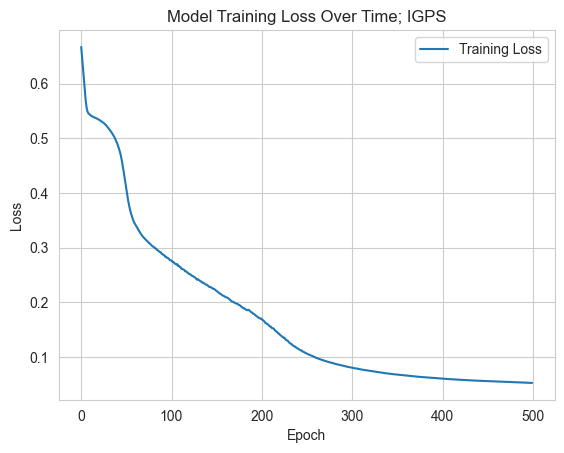

In [5]:
epochs = 500

loss_vals, cross_vals = [], []
for epoch in tqdm(range(epochs), 'Training... '):
    temp_loss = []
    for samples, labels in train:
        samples = samples.float()
        output = model(samples)

        #print(labels.float())
        #print(output)

        loss = loss_fn(output, labels.float())

        adam.zero_grad()
        loss.backward()
        adam.step()

        temp_loss.append(loss.item())

    val = sum(temp_loss[-len(train):]) / len(train)
    loss_vals.append(val)

plt.plot(loss_vals, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training Loss Over Time; IGPS')
plt.legend()
# plt.savefig(results_dir + 'loss.png', dpi=900)
plt.show()

In [6]:
model.eval()

X = valid_X
X = X.astype('float32')
with torch.no_grad():
    print(X.shape)
    out = model(torch.tensor(X)).detach().numpy()

preds = (torch.from_numpy(out) > 0.5).float()

truth = valid_y.tolist()
preds = preds.tolist()

truth = list(itertools.chain.from_iterable(truth))
preds = list(itertools.chain.from_iterable(preds))

print(truth)

(9, 9, 6)
[1, 1, 1, 0, 1, 1, 0, 0, 1]


Accuracy Score: 0.4444444444444444
Precision Score: 0.5714285714285714
Recall Score: 0.6666666666666666
F1 Score:  0.6153846153846153


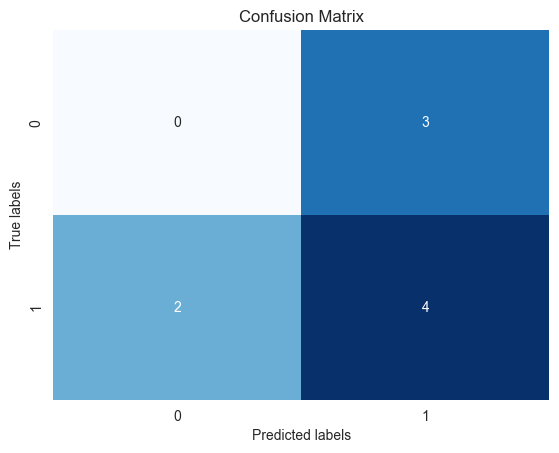

In [7]:
cm = confusion_matrix(truth, preds)

accuracy = accuracy_score(truth, preds)
print("Accuracy Score:", accuracy)

precision = precision_score(truth, preds)
print("Precision Score:", precision)

recall = recall_score(truth, preds)
print("Recall Score:", recall)

f1 = f1_score(truth, preds)
print("F1 Score: ", f1)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('results/RNN_MISO/base_struc_cm.png', dpi=900)
plt.show()

In [8]:
# grid search ;)
best_acc, best_prec, best_rec, best_f1, sum = 0, 0, 0, 0, 0
best_cm, best_model, best_params = None, None, None
for l in range(1, 5):
    for w in range(1, 101, 2):
        print(l)
        print(w)

        params = {
            'n_in': n_features,
            'n_width': w,
            'n_layers': l,
            'n_out': 1,
            'mimo': False
        }

        model = nets.RNN(**params)
        loss_fn = nn.BCELoss()
        adam = optim.Adam(model.parameters(), lr=0.001)

        epochs = 500
        loss_vals, cross_vals = [], []
        for epoch in tqdm(range(epochs), 'Training... '):
            temp_loss = []
            for samples, labels in train:
                samples = samples.float()
                output = model(samples)

                loss = loss_fn(output, labels.float())

                adam.zero_grad()
                loss.backward()
                adam.step()

                temp_loss.append(loss.item())

        model.eval()

        X = valid_X
        X = X.astype('float32')
        with torch.no_grad():
            out = model(torch.tensor(X)).detach().numpy()

        preds = (torch.from_numpy(out) > 0.5).float()

        truth = valid_y.tolist()
        preds = preds.tolist()

        truth = list(itertools.chain.from_iterable(truth))
        preds = list(itertools.chain.from_iterable(preds))

        print(preds)

        cm = confusion_matrix(truth, preds)
        accuracy = accuracy_score(truth, preds)
        precision = precision_score(truth, preds)
        recall = recall_score(truth, preds)
        f1 = f1_score(truth, preds)

        curr = f1 + accuracy
        print("F1 + Acc: ", curr)

        if curr > sum:
            best_cm = cm
            best_acc = accuracy
            best_prec = precision
            best_rec = recall
            best_f1 = f1
            best_model = model
            best_params = params
            sum = curr

1
1


Training... : 100%|██████████| 500/500 [00:03<00:00, 147.57it/s]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.4666666666666668
1
3


Training... : 100%|██████████| 500/500 [00:03<00:00, 140.52it/s]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.4666666666666668
1
5


Training... : 100%|██████████| 500/500 [00:03<00:00, 137.77it/s]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.4666666666666668
1
7


Training... : 100%|██████████| 500/500 [00:03<00:00, 130.09it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
1
9


Training... : 100%|██████████| 500/500 [00:04<00:00, 123.55it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
11


Training... : 100%|██████████| 500/500 [00:04<00:00, 119.95it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
F1 + Acc:  0.8333333333333333
1
13


Training... : 100%|██████████| 500/500 [00:04<00:00, 111.27it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
F1 + Acc:  0.8333333333333333
1
15


Training... : 100%|██████████| 500/500 [00:04<00:00, 112.70it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
F1 + Acc:  0.8333333333333333
1
17


Training... : 100%|██████████| 500/500 [00:04<00:00, 110.65it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
F1 + Acc:  0.8333333333333333
1
19


Training... : 100%|██████████| 500/500 [00:03<00:00, 126.22it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
1
21


Training... : 100%|██████████| 500/500 [00:03<00:00, 133.14it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]
F1 + Acc:  0.9898989898989898
1
23


Training... : 100%|██████████| 500/500 [00:03<00:00, 133.24it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
1
25


Training... : 100%|██████████| 500/500 [00:03<00:00, 134.43it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
F1 + Acc:  0.8333333333333333
1
27


Training... : 100%|██████████| 500/500 [00:03<00:00, 135.88it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
29


Training... : 100%|██████████| 500/500 [00:03<00:00, 138.32it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
31


Training... : 100%|██████████| 500/500 [00:04<00:00, 116.76it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
F1 + Acc:  1.0598290598290596
1
33


Training... : 100%|██████████| 500/500 [00:04<00:00, 108.22it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0]
F1 + Acc:  1.2222222222222223
1
35


Training... : 100%|██████████| 500/500 [00:04<00:00, 109.82it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
37


Training... : 100%|██████████| 500/500 [00:04<00:00, 120.07it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.2222222222222223
1
39


Training... : 100%|██████████| 500/500 [00:04<00:00, 117.51it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
41


Training... : 100%|██████████| 500/500 [00:04<00:00, 124.28it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.2222222222222223
1
43


Training... : 100%|██████████| 500/500 [00:03<00:00, 131.20it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
1
45


Training... : 100%|██████████| 500/500 [00:03<00:00, 132.79it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
47


Training... : 100%|██████████| 500/500 [00:03<00:00, 134.59it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
49


Training... : 100%|██████████| 500/500 [00:03<00:00, 137.85it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
51


Training... : 100%|██████████| 500/500 [00:03<00:00, 134.21it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
53


Training... : 100%|██████████| 500/500 [00:03<00:00, 135.53it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
55


Training... : 100%|██████████| 500/500 [00:03<00:00, 137.08it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
57


Training... : 100%|██████████| 500/500 [00:03<00:00, 136.14it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
59


Training... : 100%|██████████| 500/500 [00:03<00:00, 133.23it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
61


Training... : 100%|██████████| 500/500 [00:03<00:00, 132.94it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
63


Training... : 100%|██████████| 500/500 [00:03<00:00, 129.37it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
65


Training... : 100%|██████████| 500/500 [00:03<00:00, 127.60it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
67


Training... : 100%|██████████| 500/500 [00:03<00:00, 126.57it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
69


Training... : 100%|██████████| 500/500 [00:03<00:00, 125.87it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
71


Training... : 100%|██████████| 500/500 [00:03<00:00, 125.81it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
73


Training... : 100%|██████████| 500/500 [00:04<00:00, 121.31it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
75


Training... : 100%|██████████| 500/500 [00:04<00:00, 120.12it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
77


Training... : 100%|██████████| 500/500 [00:04<00:00, 119.58it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.2222222222222223
1
79


Training... : 100%|██████████| 500/500 [00:04<00:00, 119.68it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
81


Training... : 100%|██████████| 500/500 [00:04<00:00, 121.24it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
83


Training... : 100%|██████████| 500/500 [00:04<00:00, 120.25it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
85


Training... : 100%|██████████| 500/500 [00:04<00:00, 120.54it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
87


Training... : 100%|██████████| 500/500 [00:04<00:00, 118.03it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
89


Training... : 100%|██████████| 500/500 [00:04<00:00, 114.37it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
91


Training... : 100%|██████████| 500/500 [00:04<00:00, 111.21it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
93


Training... : 100%|██████████| 500/500 [00:04<00:00, 110.36it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
95


Training... : 100%|██████████| 500/500 [00:04<00:00, 109.35it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
1
97


Training... : 100%|██████████| 500/500 [00:04<00:00, 110.73it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.2222222222222223
1
99


Training... : 100%|██████████| 500/500 [00:04<00:00, 110.88it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
2
1


Training... : 100%|██████████| 500/500 [00:05<00:00, 85.97it/s]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.4666666666666668
2
3


Training... : 100%|██████████| 500/500 [00:06<00:00, 78.72it/s]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.4666666666666668
2
5


Training... : 100%|██████████| 500/500 [00:06<00:00, 80.97it/s]


[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
2
7


Training... : 100%|██████████| 500/500 [00:05<00:00, 83.71it/s]


[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
2
9


Training... : 100%|██████████| 500/500 [00:06<00:00, 81.03it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0]
F1 + Acc:  1.2222222222222223
2
11


Training... : 100%|██████████| 500/500 [00:05<00:00, 84.70it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
F1 + Acc:  0.8333333333333333
2
13


Training... : 100%|██████████| 500/500 [00:05<00:00, 84.66it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
F1 + Acc:  0.8333333333333333
2
15


Training... : 100%|██████████| 500/500 [00:06<00:00, 83.11it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
2
17


Training... : 100%|██████████| 500/500 [00:06<00:00, 82.25it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.2222222222222223
2
19


Training... : 100%|██████████| 500/500 [00:05<00:00, 83.86it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
2
21


Training... : 100%|██████████| 500/500 [00:05<00:00, 84.69it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
2
23


Training... : 100%|██████████| 500/500 [00:05<00:00, 87.81it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
F1 + Acc:  0.8333333333333333
2
25


Training... : 100%|██████████| 500/500 [00:05<00:00, 90.71it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
2
27


Training... : 100%|██████████| 500/500 [00:05<00:00, 93.00it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.2222222222222223
2
29


Training... : 100%|██████████| 500/500 [00:05<00:00, 93.68it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.2222222222222223
2
31


Training... : 100%|██████████| 500/500 [00:05<00:00, 92.93it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
F1 + Acc:  0.8333333333333333
2
33


Training... : 100%|██████████| 500/500 [00:05<00:00, 91.85it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.4358974358974357
2
35


Training... : 100%|██████████| 500/500 [00:05<00:00, 88.89it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
F1 + Acc:  1.0598290598290596
2
37


Training... : 100%|██████████| 500/500 [00:05<00:00, 84.99it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
2
39


Training... : 100%|██████████| 500/500 [00:05<00:00, 83.92it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
F1 + Acc:  0.8333333333333333
2
41


Training... : 100%|██████████| 500/500 [00:05<00:00, 85.87it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.4358974358974357
2
43


Training... : 100%|██████████| 500/500 [00:05<00:00, 86.23it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
2
45


Training... : 100%|██████████| 500/500 [00:05<00:00, 85.22it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
2
47


Training... : 100%|██████████| 500/500 [00:05<00:00, 84.26it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
F1 + Acc:  0.8333333333333333
2
49


Training... : 100%|██████████| 500/500 [00:06<00:00, 82.99it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
2
51


Training... : 100%|██████████| 500/500 [00:06<00:00, 82.47it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
2
53


Training... : 100%|██████████| 500/500 [00:06<00:00, 81.99it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
2
55


Training... : 100%|██████████| 500/500 [00:06<00:00, 82.79it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.4358974358974357
2
57


Training... : 100%|██████████| 500/500 [00:06<00:00, 80.65it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
2
59


Training... : 100%|██████████| 500/500 [00:06<00:00, 80.81it/s]


[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.6111111111111112
2
61


Training... : 100%|██████████| 500/500 [00:06<00:00, 80.61it/s]


[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2222222222222223
2
63


Training... : 100%|██████████| 500/500 [00:06<00:00, 78.83it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
2
65


Training... : 100%|██████████| 500/500 [00:06<00:00, 78.47it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.2222222222222223
2
67


Training... : 100%|██████████| 500/500 [00:06<00:00, 78.38it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.4358974358974357
2
69


Training... : 100%|██████████| 500/500 [00:06<00:00, 79.97it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
2
71


Training... : 100%|██████████| 500/500 [00:06<00:00, 76.11it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.2222222222222223
2
73


Training... : 100%|██████████| 500/500 [00:07<00:00, 70.86it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.4358974358974357
2
75


Training... : 100%|██████████| 500/500 [00:08<00:00, 60.36it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
2
77


Training... : 100%|██████████| 500/500 [00:08<00:00, 60.91it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
2
79


Training... : 100%|██████████| 500/500 [00:07<00:00, 68.35it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
2
81


Training... : 100%|██████████| 500/500 [00:06<00:00, 71.81it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
F1 + Acc:  0.8333333333333333
2
83


Training... : 100%|██████████| 500/500 [00:06<00:00, 72.40it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
2
85


Training... : 100%|██████████| 500/500 [00:07<00:00, 69.46it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.4358974358974357
2
87


Training... : 100%|██████████| 500/500 [00:07<00:00, 67.12it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
2
89


Training... : 100%|██████████| 500/500 [00:07<00:00, 66.78it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.2222222222222223
2
91


Training... : 100%|██████████| 500/500 [00:07<00:00, 63.33it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.2222222222222223
2
93


Training... : 100%|██████████| 500/500 [00:07<00:00, 66.63it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
2
95


Training... : 100%|██████████| 500/500 [00:07<00:00, 66.89it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
2
97


Training... : 100%|██████████| 500/500 [00:07<00:00, 67.04it/s]


[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]
F1 + Acc:  1.1555555555555554
2
99


Training... : 100%|██████████| 500/500 [00:07<00:00, 65.29it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.2222222222222223
3
1


Training... : 100%|██████████| 500/500 [00:06<00:00, 74.32it/s]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.4666666666666668
3
3


Training... : 100%|██████████| 500/500 [00:07<00:00, 70.91it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
3
5


Training... : 100%|██████████| 500/500 [00:07<00:00, 68.78it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
F1 + Acc:  0.8333333333333333
3
7


Training... : 100%|██████████| 500/500 [00:07<00:00, 67.89it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
F1 + Acc:  0.8333333333333333
3
9


Training... : 100%|██████████| 500/500 [00:07<00:00, 68.25it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
F1 + Acc:  1.0598290598290596
3
11


Training... : 100%|██████████| 500/500 [00:07<00:00, 67.69it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
F1 + Acc:  1.0598290598290596
3
13


Training... : 100%|██████████| 500/500 [00:07<00:00, 67.40it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0]
F1 + Acc:  1.6111111111111112
3
15


Training... : 100%|██████████| 500/500 [00:07<00:00, 66.40it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
3
17


Training... : 100%|██████████| 500/500 [00:07<00:00, 66.26it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
3
19


Training... : 100%|██████████| 500/500 [00:07<00:00, 67.45it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
3
21


Training... : 100%|██████████| 500/500 [00:07<00:00, 67.80it/s]


[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.4358974358974357
3
23


Training... : 100%|██████████| 500/500 [00:07<00:00, 67.04it/s]


[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]
F1 + Acc:  0.9898989898989898
3
25


Training... : 100%|██████████| 500/500 [00:07<00:00, 65.51it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
3
27


Training... : 100%|██████████| 500/500 [00:07<00:00, 63.98it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
F1 + Acc:  0.8333333333333333
3
29


Training... : 100%|██████████| 500/500 [00:07<00:00, 65.02it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
F1 + Acc:  1.0598290598290596
3
31


Training... : 100%|██████████| 500/500 [00:07<00:00, 66.01it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
3
33


Training... : 100%|██████████| 500/500 [00:07<00:00, 65.83it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
3
35


Training... : 100%|██████████| 500/500 [00:07<00:00, 63.91it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
3
37


Training... : 100%|██████████| 500/500 [00:08<00:00, 62.24it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
3
39


Training... : 100%|██████████| 500/500 [00:08<00:00, 61.17it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.4358974358974357
3
41


Training... : 100%|██████████| 500/500 [00:08<00:00, 61.65it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
F1 + Acc:  1.0598290598290596
3
43


Training... : 100%|██████████| 500/500 [00:08<00:00, 62.33it/s]


[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.3939393939393938
3
45


Training... : 100%|██████████| 500/500 [00:08<00:00, 62.17it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.4358974358974357
3
47


Training... : 100%|██████████| 500/500 [00:08<00:00, 62.16it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
3
49


Training... : 100%|██████████| 500/500 [00:08<00:00, 58.28it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
3
51


Training... : 100%|██████████| 500/500 [00:09<00:00, 53.06it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
3
53


Training... : 100%|██████████| 500/500 [00:09<00:00, 54.30it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
F1 + Acc:  1.0598290598290596
3
55


Training... : 100%|██████████| 500/500 [00:08<00:00, 59.37it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
3
57


Training... : 100%|██████████| 500/500 [00:08<00:00, 58.67it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
3
59


Training... : 100%|██████████| 500/500 [00:08<00:00, 56.61it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
3
61


Training... : 100%|██████████| 500/500 [00:08<00:00, 57.36it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.2222222222222223
3
63


Training... : 100%|██████████| 500/500 [00:08<00:00, 57.53it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]
F1 + Acc:  0.9898989898989898
3
65


Training... : 100%|██████████| 500/500 [00:08<00:00, 56.80it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.4358974358974357
3
67


Training... : 100%|██████████| 500/500 [00:08<00:00, 55.94it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
3
69


Training... : 100%|██████████| 500/500 [00:09<00:00, 53.93it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.4358974358974357
3
71


Training... : 100%|██████████| 500/500 [00:09<00:00, 52.29it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
3
73


Training... : 100%|██████████| 500/500 [00:09<00:00, 52.21it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
3
75


Training... : 100%|██████████| 500/500 [00:09<00:00, 51.62it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
3
77


Training... : 100%|██████████| 500/500 [00:09<00:00, 51.58it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.2222222222222223
3
79


Training... : 100%|██████████| 500/500 [00:09<00:00, 51.08it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
3
81


Training... : 100%|██████████| 500/500 [00:10<00:00, 49.26it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
3
83


Training... : 100%|██████████| 500/500 [00:11<00:00, 45.21it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
3
85


Training... : 100%|██████████| 500/500 [00:10<00:00, 49.81it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
3
87


Training... : 100%|██████████| 500/500 [00:09<00:00, 50.03it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
3
89


Training... : 100%|██████████| 500/500 [00:09<00:00, 50.42it/s]


[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.4358974358974357
3
91


Training... : 100%|██████████| 500/500 [00:10<00:00, 47.96it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.4358974358974357
3
93


Training... : 100%|██████████| 500/500 [00:10<00:00, 47.42it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
3
95


Training... : 100%|██████████| 500/500 [00:10<00:00, 45.90it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
3
97


Training... : 100%|██████████| 500/500 [00:10<00:00, 46.35it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
3
99


Training... : 100%|██████████| 500/500 [00:10<00:00, 45.97it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.4358974358974357
4
1


Training... : 100%|██████████| 500/500 [00:09<00:00, 55.10it/s]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.4666666666666668
4
3


Training... : 100%|██████████| 500/500 [00:09<00:00, 54.31it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
5


Training... : 100%|██████████| 500/500 [00:09<00:00, 54.52it/s]


[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
7


Training... : 100%|██████████| 500/500 [00:09<00:00, 54.71it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
F1 + Acc:  1.0598290598290596
4
9


Training... : 100%|██████████| 500/500 [00:09<00:00, 54.61it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]
F1 + Acc:  0.9898989898989898
4
11


Training... : 100%|██████████| 500/500 [00:09<00:00, 52.55it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
13


Training... : 100%|██████████| 500/500 [00:09<00:00, 52.64it/s]


[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
4
15


Training... : 100%|██████████| 500/500 [00:09<00:00, 50.72it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
4
17


Training... : 100%|██████████| 500/500 [00:10<00:00, 46.68it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
4
19


Training... : 100%|██████████| 500/500 [00:09<00:00, 50.08it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
F1 + Acc:  0.8333333333333333
4
21


Training... : 100%|██████████| 500/500 [00:09<00:00, 53.29it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
23


Training... : 100%|██████████| 500/500 [00:09<00:00, 53.58it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0]
F1 + Acc:  1.4358974358974357
4
25


Training... : 100%|██████████| 500/500 [00:09<00:00, 53.90it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
4
27


Training... : 100%|██████████| 500/500 [00:09<00:00, 53.51it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
F1 + Acc:  1.0598290598290596
4
29


Training... : 100%|██████████| 500/500 [00:09<00:00, 52.75it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
31


Training... : 100%|██████████| 500/500 [00:09<00:00, 51.33it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
33


Training... : 100%|██████████| 500/500 [00:09<00:00, 50.18it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
35


Training... : 100%|██████████| 500/500 [00:09<00:00, 50.88it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
4
37


Training... : 100%|██████████| 500/500 [00:09<00:00, 50.53it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0]
F1 + Acc:  1.4358974358974357
4
39


Training... : 100%|██████████| 500/500 [00:09<00:00, 50.16it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0]
F1 + Acc:  1.4358974358974357
4
41


Training... : 100%|██████████| 500/500 [00:10<00:00, 49.10it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
43


Training... : 100%|██████████| 500/500 [00:10<00:00, 47.84it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
45


Training... : 100%|██████████| 500/500 [00:10<00:00, 48.50it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
47


Training... : 100%|██████████| 500/500 [00:10<00:00, 49.81it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.4358974358974357
4
49


Training... : 100%|██████████| 500/500 [00:10<00:00, 48.73it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
4
51


Training... : 100%|██████████| 500/500 [00:10<00:00, 47.26it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
53


Training... : 100%|██████████| 500/500 [00:10<00:00, 45.78it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
55


Training... : 100%|██████████| 500/500 [00:11<00:00, 44.87it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.4358974358974357
4
57


Training... : 100%|██████████| 500/500 [00:12<00:00, 41.41it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
59


Training... : 100%|██████████| 500/500 [00:13<00:00, 38.12it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
61


Training... : 100%|██████████| 500/500 [00:11<00:00, 42.41it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
63


Training... : 100%|██████████| 500/500 [00:10<00:00, 45.49it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
65


Training... : 100%|██████████| 500/500 [00:11<00:00, 44.99it/s]


[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0]
F1 + Acc:  1.2222222222222223
4
67


Training... : 100%|██████████| 500/500 [00:11<00:00, 44.09it/s]


[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.0598290598290596
4
69


Training... : 100%|██████████| 500/500 [00:11<00:00, 42.88it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
F1 + Acc:  1.0598290598290596
4
71


Training... : 100%|██████████| 500/500 [00:12<00:00, 40.35it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
73


Training... : 100%|██████████| 500/500 [00:12<00:00, 39.27it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
F1 + Acc:  1.4358974358974357
4
75


Training... : 100%|██████████| 500/500 [00:12<00:00, 39.88it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
77


Training... : 100%|██████████| 500/500 [00:12<00:00, 39.32it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
F1 + Acc:  1.0598290598290596
4
79


Training... : 100%|██████████| 500/500 [00:12<00:00, 40.02it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
F1 + Acc:  1.0598290598290596
4
81


Training... : 100%|██████████| 500/500 [00:12<00:00, 39.17it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
83


Training... : 100%|██████████| 500/500 [00:12<00:00, 38.76it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
85


Training... : 100%|██████████| 500/500 [00:13<00:00, 37.18it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
87


Training... : 100%|██████████| 500/500 [00:13<00:00, 35.92it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
89


Training... : 100%|██████████| 500/500 [00:13<00:00, 37.81it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
91


Training... : 100%|██████████| 500/500 [00:14<00:00, 35.31it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]
F1 + Acc:  0.9898989898989898
4
93


Training... : 100%|██████████| 500/500 [00:15<00:00, 32.14it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
95


Training... : 100%|██████████| 500/500 [00:14<00:00, 34.35it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
F1 + Acc:  1.0598290598290596
4
97


Training... : 100%|██████████| 500/500 [00:14<00:00, 34.69it/s]


[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 + Acc:  1.2698412698412698
4
99


Training... : 100%|██████████| 500/500 [00:14<00:00, 34.26it/s]

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
F1 + Acc:  1.0598290598290596


Accuracy Score: 0.7777777777777778
Precision Score: 0.8333333333333334
Recall Score: 0.8333333333333334
F1 Score:  0.8333333333333334
Best Parameters:
{'n_in': 6, 'n_width': 59, 'n_layers': 2, 'n_out': 1, 'mimo': False}


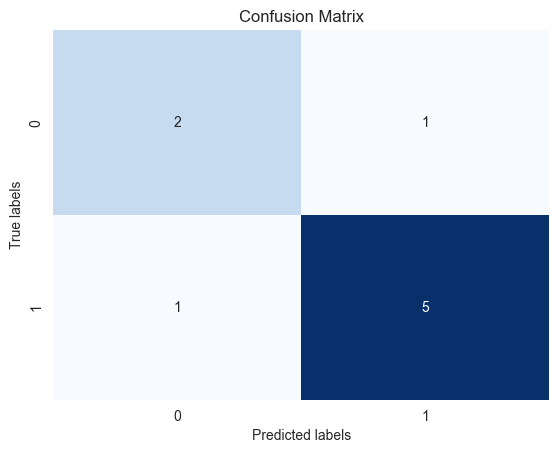

In [9]:
print("Accuracy Score:", best_acc)
print("Precision Score:", best_prec)
print("Recall Score:", best_rec)
print("F1 Score: ", best_f1)

print("Best Parameters:")
print(best_params)

sns.heatmap(best_cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('results/RNN_MISO/grid_struc_cm.png', dpi=900)
plt.show()